<a href="https://colab.research.google.com/github/brendatransito/Tumor-Image-Classification/blob/main/02_1_cnn_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ResNet 101

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Si no tienes GPU, aquí puedes verificar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Proyecto_PTI")

from prepare_dataset import prepare_dataloaders_kaggle, load_clean_split_kaggle

Mounted at /content/drive


In [ ]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"

from prepare_dataset import prepare_dataloaders_kaggle

BASE_DIR = "/kaggle/input/brain-tumor-mri-dataset"

# 1) Con data augmentation
train_loader_aug, val_loader_aug, test_loader_aug, classes = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=True
)

# 2) Sin data augmentation (solo resize+normalize)
train_loader_noaug, val_loader_noaug, test_loader_noaug, _ = prepare_dataloaders_kaggle(
    BASE_DIR, batch_size=32, augment_train=False
)


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1321 imágenes
glioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Training: 1339 imágenes
meningioma - /kaggle/input/brain-tumor-mri-dataset/Testing: 306 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Training: 1595 imágenes
notumor - /kaggle/input/brain-tumor-mri-dataset/Testing: 405 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Training: 1457 imágenes
pituitary - /kaggle/input/brain-tumor-mri-dataset/Testing: 300 imágenes

Total imágenes sin duplicados: 6726

Train: 4708 | Val: 1009 | Test: 1009

🔢 Mapeo clase → índice: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Usando DATA AUGMENTATION en entrenamiento
Clases detectadas: ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma 

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# --- Modelo con augment ---
model_aug = models.resnet101(weights="IMAGENET1K_V1")
num_features = model_aug.fc.in_features
model_aug.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, len(classes))
)

model_aug = model_aug.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_aug = optim.AdamW(model_aug.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_aug, mode='min', factor=0.1, patience=3
)

EPOCHS = 10
history_aug = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_aug, train_loader_aug, optimizer_aug, criterion)
    val_loss, val_acc     = eval_one_epoch(model_aug, val_loader_aug, criterion)

    history_aug["train_loss"].append(train_loss)
    history_aug["val_loss"].append(val_loss)
    history_aug["train_acc"].append(train_acc)
    history_aug["val_acc"].append(val_acc)

    scheduler_aug.step(val_loss)

    print(f"\n[Aug] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_aug.state_dict(), "/content/drive/MyDrive/Proyecto_PTI/resnet101_aug_best.pth")
        print(" Mejor modelo (Aug) guardado")


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 193MB/s]



[Aug] Epoch 1/10
  Train Loss: 0.3118 | Train Acc: 0.8881
  Val   Loss: 0.2133   | Val   Acc: 0.9257
 Mejor modelo (Aug) guardado

[Aug] Epoch 2/10
  Train Loss: 0.1580 | Train Acc: 0.9507
  Val   Loss: 0.1130   | Val   Acc: 0.9633
 Mejor modelo (Aug) guardado

[Aug] Epoch 3/10
  Train Loss: 0.1259 | Train Acc: 0.9556
  Val   Loss: 0.0535   | Val   Acc: 0.9822
 Mejor modelo (Aug) guardado

[Aug] Epoch 4/10
  Train Loss: 0.0941 | Train Acc: 0.9720
  Val   Loss: 0.0940   | Val   Acc: 0.9643

[Aug] Epoch 5/10
  Train Loss: 0.0944 | Train Acc: 0.9690
  Val   Loss: 0.0418   | Val   Acc: 0.9841
 Mejor modelo (Aug) guardado

[Aug] Epoch 6/10
  Train Loss: 0.0568 | Train Acc: 0.9828
  Val   Loss: 0.0451   | Val   Acc: 0.9881

[Aug] Epoch 7/10
  Train Loss: 0.0534 | Train Acc: 0.9830
  Val   Loss: 0.0514   | Val   Acc: 0.9812

[Aug] Epoch 8/10
  Train Loss: 0.0839 | Train Acc: 0.9743
  Val   Loss: 0.0670   | Val   Acc: 0.9752

[Aug] Epoch 9/10
  Train Loss: 0.0721 | Train Acc: 0.9771
  Val   L

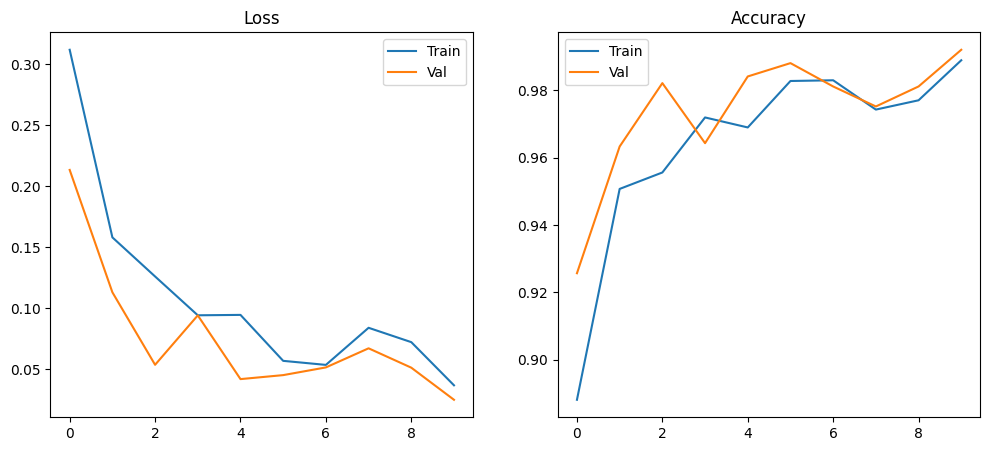

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_aug["train_loss"], label="Train")
plt.plot(history_aug["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_aug["train_acc"], label="Train")
plt.plot(history_aug["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [ ]:
# --- Modelo sin augment ---

model_noaug = models.resnet101(weights="IMAGENET1K_V1")
num_features = model_noaug.fc.in_features
model_noaug.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, len(classes))
)

model_noaug = model_noaug.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_noaug = optim.AdamW(model_noaug.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler_noaug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_noaug, mode='min', factor=0.1, patience=3
)

history_noaug = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_loss_noaug = float("inf")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_noaug, train_loader_noaug, optimizer_noaug, criterion)
    val_loss, val_acc     = eval_one_epoch(model_noaug, val_loader_noaug, criterion)

    history_noaug["train_loss"].append(train_loss)
    history_noaug["val_loss"].append(val_loss)
    history_noaug["train_acc"].append(train_acc)
    history_noaug["val_acc"].append(val_acc)

    scheduler_noaug.step(val_loss)

    print(f"\n[NoAug] Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}   | Val   Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_noaug:
        best_val_loss_noaug = val_loss
        torch.save(model_noaug.state_dict(), "/content/drive/MyDrive/Proyecto_PTI/resnet101_noaug_best.pth")
        print("  Mejor modelo (NoAug) guardado")



[NoAug] Epoch 1/10
  Train Loss: 0.2602 | Train Acc: 0.9114
  Val   Loss: 0.1519   | Val   Acc: 0.9514
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 2/10
  Train Loss: 0.0803 | Train Acc: 0.9764
  Val   Loss: 0.0489   | Val   Acc: 0.9861
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 3/10
  Train Loss: 0.0619 | Train Acc: 0.9785
  Val   Loss: 0.0508   | Val   Acc: 0.9861

[NoAug] Epoch 4/10
  Train Loss: 0.0331 | Train Acc: 0.9913
  Val   Loss: 0.0898   | Val   Acc: 0.9703

[NoAug] Epoch 5/10
  Train Loss: 0.0472 | Train Acc: 0.9862
  Val   Loss: 0.1227   | Val   Acc: 0.9623

[NoAug] Epoch 6/10
  Train Loss: 0.0208 | Train Acc: 0.9941
  Val   Loss: 0.0575   | Val   Acc: 0.9861

[NoAug] Epoch 7/10
  Train Loss: 0.0082 | Train Acc: 0.9979
  Val   Loss: 0.0429   | Val   Acc: 0.9881
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 8/10
  Train Loss: 0.0050 | Train Acc: 0.9996
  Val   Loss: 0.0417   | Val   Acc: 0.9891
  Mejor modelo (NoAug) guardado

[NoAug] Epoch 9/10
  Train Loss: 0.0034

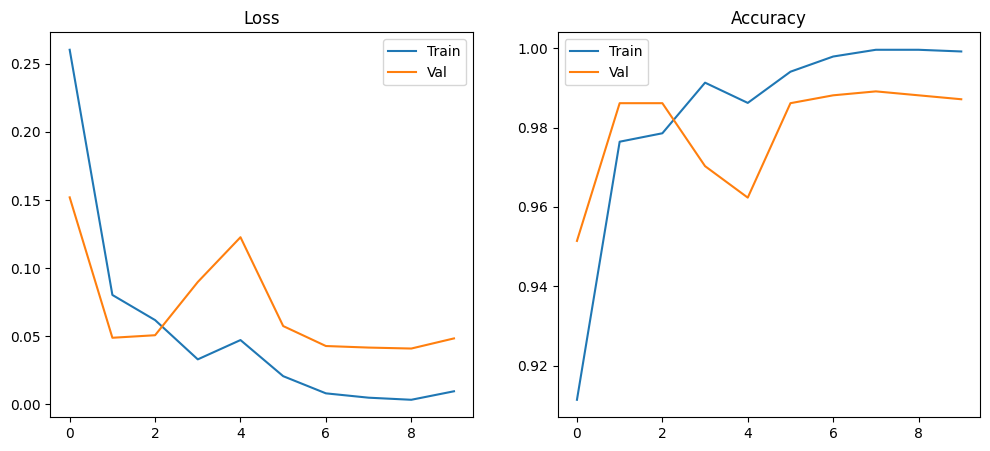

In [ ]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_noaug["train_loss"], label="Train")
plt.plot(history_noaug["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_noaug["train_acc"], label="Train")
plt.plot(history_noaug["val_acc"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [ ]:
# Evaluar modelo con augment
model_aug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/resnet101_aug_best.pth"))
test_loss_aug, test_acc_aug = eval_one_epoch(model_aug, test_loader_aug, criterion)

# Evaluar modelo sin augment
model_noaug.load_state_dict(torch.load("/content/drive/MyDrive/Proyecto_PTI/resnet101_noaug_best.pth"))
test_loss_noaug, test_acc_noaug = eval_one_epoch(model_noaug, test_loader_noaug, criterion)

print(f"Test (Aug)   -> Loss: {test_loss_aug:.4f} | Acc: {test_acc_aug:.4f}")
print(f"Test (NoAug) -> Loss: {test_loss_noaug:.4f} | Acc: {test_acc_noaug:.4f}")


Test (Aug)   -> Loss: 0.0325 | Acc: 0.9891
Test (NoAug) -> Loss: 0.0436 | Acc: 0.9871


In [ ]:
model_aug.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader_aug:
        imgs = imgs.to(device)
        output = model_aug(imgs)
        preds = output.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# Reporte detallado
print("Reporte de clasificación con data Augmentation")
print(classification_report(y_true, y_pred, target_names=classes))


Reporte de clasificación con data Augmentation
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       243
  meningioma       0.98      0.98      0.98       246
     notumor       1.00      0.99      0.99       259
   pituitary       0.99      0.99      0.99       261

    accuracy                           0.99      1009
   macro avg       0.99      0.99      0.99      1009
weighted avg       0.99      0.99      0.99      1009



In [ ]:
model_noaug.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader_noaug:
        imgs = imgs.to(device)
        output = model_noaug(imgs)
        preds = output.argmax(1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# Reporte detallado
print("Reporte de clasificación sin data Augmentation")
print(classification_report(y_true, y_pred, target_names=classes))


Reporte de clasificación sin data Augmentation
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       243
  meningioma       0.98      0.97      0.98       246
     notumor       1.00      0.99      1.00       259
   pituitary       0.98      1.00      0.99       261

    accuracy                           0.99      1009
   macro avg       0.99      0.99      0.99      1009
weighted avg       0.99      0.99      0.99      1009



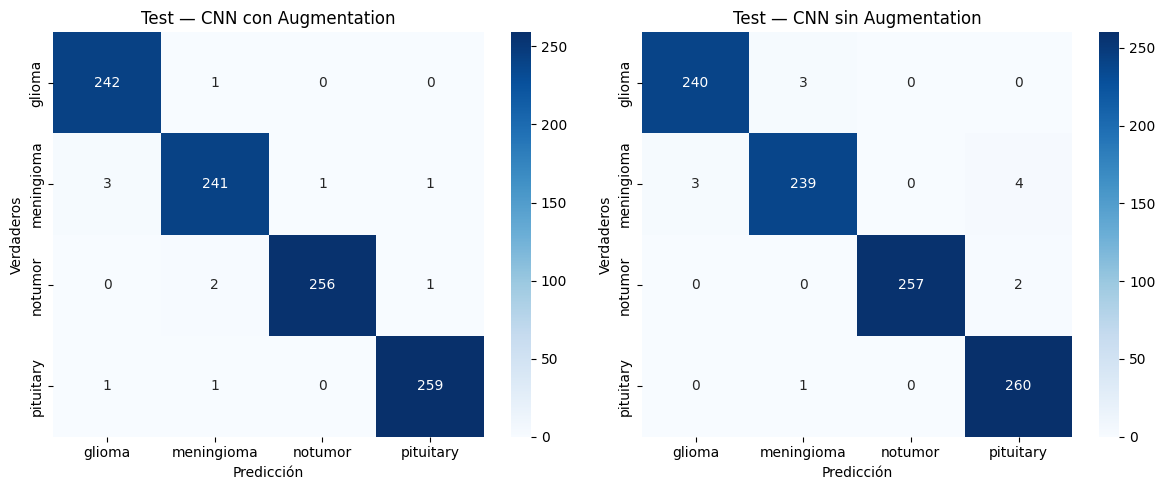

In [ ]:
def get_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Aug
y_true_aug, y_pred_aug = get_preds(model_aug, test_loader_aug)
cm_aug = confusion_matrix(y_true_aug, y_pred_aug).astype(int)

# NoAug
y_true_noaug, y_pred_noaug = get_preds(model_noaug, test_loader_noaug)
cm_noaug = confusion_matrix(y_true_noaug, y_pred_noaug).astype(int)

plt.figure(figsize=(12,5))

# AUGMENTATION
plt.subplot(1,2,1)
sns.heatmap(cm_aug, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Test — CNN con Augmentation")
plt.xlabel("Predicción"); plt.ylabel("Verdaderos")

# SIN AUG
plt.subplot(1,2,2)
sns.heatmap(cm_noaug, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Test — CNN sin Augmentation")
plt.xlabel("Predicción"); plt.ylabel("Verdaderos")

plt.tight_layout()
plt.show()

